# Sarah Spence -PA2

In [1]:
# imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Import data science algorithms and helpers 
import common_helpers as common
from data_processing import FDR_feature_ranking as FDR
from data_processing import normalization_and_standardization as norm
from machine_learning import bayes_classifier as bayes
from machine_learning import bayes_classifier_model as bayes_model
from machine_learning import expectation_maximization as EM
from machine_learning import parzen_window as parzen
from machine_learning import k_fold_validation as k_fold

In [4]:
generated_num_features = pd.read_csv("data_files/trainFeatures42k.csv", header=None)

## Problem 1 - Computational Statistics 
30 Points Total

### 1. (15 points) Develop and implement the Expectation Maximization method for a generic number of clusters, features and observations.

Pseudo-code:

def SIMPLE_EXPECTATION_MAXIMIZATION(x, k, prob, m, std, threshold):

    cols <- num cols in x
    rows <- num rows in x

    itializeRows <- create a matrix of ones of size (rows, 1)
    initializeCols <- create a matrix of ones of size (1, cols)

    iterations <- 0

    while True:

        prev_mean <- make a copy of m
        prev_std <- make a copy of std
        prev_prob <- make a copy of prob

        g <- empty array
        progKg <- empty array

        # Expectation step
        for i in range 0:k:
            val <- get the ith column of the mean matrix and transpose 
            calc_1 <- multiply val by a matrix of ones of size (1, cols)
            calc_2 <- subtract calc_1 from x
            calc_3 <- square all elements in calc 2
            calc_4 <- run calculcation np.exp(np.divide(np.divide(-1 * np.sum(calc_3, axis = 0), np.power(std[i], 2)), 2))
            calc_5 <- perform calculation np.power(math.sqrt(2 * math.pi)* std[cluster], rows)
            calc_e_step <- divide clac_4 by calc_5
            g <- append calc_e_step to g
            probKg <- append prob[:, i] * g[i] to probKg

        g <- convert g to numpy array
        probKg <- convert probKg to numpy array

        calc <- take the sum of all rows of probKg
        prob_ikn <- divide probKg by the product of reshaped_calc and a k X 1 matrix of ones

        # Maximization Step

        sum_prob_ikn <- sum of all cols in prob_ikn
        for i in range 0:k:
            calc_1 <- matrix multiplication on initializeRows and prob_ikn[i, :]
            calc_2 <- multiply calc_1 and x
            calc_3 <- divide calc_2 by sum_prob_ikn[i]
            m[:, i] <- the sum of all cols in calc 3

            calc_1 <- multiply m[:, i] by initializeCols
            calc_2 <- square all elements in x - calc_2 
            calc_3 <- multiply calc_2 and prob_ikn[i, :] then take the sum across all rows
            calc_4 <- divide calc_3 by sum_prob_ikn[i]
            calc_5 <- divide calc_4 by rows
            std[i] <- take the square root of calc_5
        
        prob <- divide sum_prob_ikn by the sum of sum_prob_ikn
        
        # Determine convergence
        mean_delta = max(np.sqrt(np.sum(np.power(m - prev_mean, 2), axis=0)))
        s_mean = np.mean(np.sqrt(np.sum(np.power(m, 2), axis=0)))
        conv_mean = mean_delta <= (s_mean * threshold)

        std_delta = math.sqrt(np.sum(np.power(std - prev_std, 2), axis=0))
        s_std = np.mean(np.sqrt(np.sum(np.power(std, 2))))
        conv_std = std_delta <= (s_std * threshold)

        prob_delta = max(np.sqrt(np.sum(np.power(prob - prev_prob, 2), axis=0)))
        s_prob = np.mean(math.sqrt(np.sum(np.power(prob, 2))))
        conv_prob = prob_delta <= (s_prob * threshold)


        # If the mean, std, and probabiity have converged, break
        if conv_mean and conv_std  and conv_prob:
            break

    return prob, m, std, prob_ikn, iterations

#### See the code for this algorithm in the machine_learning/expectation_maximization.py file

### 2. (15 points total) Apply your implementation using the features generated from HW 2. 
Identify and use the top two ranked features to separate three numerical values, e.g., 0, 1, 4. This will require that k = 3. Use 100 observations for each of the three numbers.

In [5]:
# Rename data columns to be indexed by 0
columns = ["label"] + [i for i in range(60)]
generated_num_features.set_axis(columns, axis=1, inplace=True)

labels = [i for i in range(10)]

# Generate the FDR table to rank features by class combinations for classes 0, 1, and 4
FDR_table, _, rankings = FDR.FDR_multiclass_feature_ranking(generated_num_features, [0, 1, 4], "label", "sum")
FDR_table

,class combinations,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,0 vs. rest,1.325256,0.255820,0.128279,0.002017,0.970632,0.004775,0.234047,0.004373,0.008919,0.058024,0.038586,0.000696,0.038735,0.010703,0.006912,0.003460,0.006619,0.002539,0.008286,0.031836,2.353779,0.506806,0.128745,0.166735,0.004132,0.000431,0.131638,0.075195,0.023656,0.064356,0.024790,0.024631,0.006895,0.070535,0.000662,0.023829,0.000359,0.009664,0.004764,0.083516,0.462854,0.000274,1.226648,0.086013,0.044070,0.048264,0.251432,0.001831,0.042225,0.015487,0.008370,0.009667,0.028293,0.030895,0.021684,0.019457,0.000509,0.013225,0.031244,0.005341
1,1 vs. rest,0.129503,0.060734,0.129896,0.021977,0.005897,0.019788,0.153930,0.012081,0.000547,0.000435,0.116606,0.114315,0.164304,0.006533,0.005780,0.068386,0.015697,0.028051,0.042117,0.000810,3.081181,0.996539,0.050958,0.074599,0.024863,0.000018,0.005877,0.006931,0.223421,0.002294,0.295796,0.180545,0.081783,0.000015,0.014543,0.009074,0.010710,0.017408,0.013598,0.007049,0.015896,0.008289,0.038248,0.338424,0.321322,0.593496,0.063258,0.002649,0.041663,0.029045,0.006240,0.076545,0.053101,0.012006,0.001030,0.011069,0.000868,0.044990,0.026074,0.007561
2,4 vs. rest,0.096326,0.025827,0.317742,0.027625,0.510723,0.014681,0.036768,0.184603,0.007633,0.022759,0.013400,0.081295,0.048384,0.000030,0.008328,0.043175,0.014010,0.000884,0.007851,0.090728,0.199545,0.190943,0.251274,0.014661,0.033112,0.007958,0.002044,0.233451,0.023214,0.035490,0.001012,0.000067,0.001546,0.005116,0.061902,0.003123,0.026989,0.000925,0.000258,0.024298,1.039454,0.000904,0.891979,0.025128,0.257124,0.000059,0.350181,0.000074,0.104906,0.025254,0.066792,0.018072,0.087941,0.000085,0.014994,0.002232,0.092064,0.014654,0.010690,0.001633
3,sum,1.551085,0.342382,0.575917,0.051618,1.487251,0.039245,0.424745,0.201057,0.017099,0.081218,0.168591,0.196305,0.251423,0.017267,0.021020,0.115021,0.036327,0.031474,0.058254,0.123373,5.634506,1.694288,0.430978,0.255995,0.062107,0.008407,0.139559,0.315577,0.270291,0.102139,0.321598,0.205243,0.090224,0.075666,0.077108,0.036027,0.038058,0.027997,0.018619,0.114863,1.518204,0.009468,2.156875,0.449566,0.622515,0.641819,0.664870,0.004554,0.188794,0.069786,0.081401,0.104284,0.169336,0.042986,0.037708,0.032758,0.093441,0.072868,0.068009,0.014536


In [6]:
print(f"The top two features to separate classes 0, 1, and 4 are {rankings[:2]}")

The top two features to separate classes 0, 1, and 4 are [20, 42]


In [7]:
# Get the top two features from the dataframe
top_features_df = generated_num_features.filter(["label"] + rankings[:2], axis=1)

# Get 100 class examples of classes [0, 1, 4]
number_classes = common.split_by_class(top_features_df, [0, 1, 4], "label", 100)
new_num_features = common.reformat_df_by_class(number_classes.values())

In [8]:
# split data and labels
new_labels, new_features = common.split_labels(new_num_features, "label")
new_features = np.array(new_features)

# get values for expectation maximization algorithm
k, x, m, std, prob = EM.prepare_data_EM(new_features, 3, np.array([0.5377, 1.8339, -2.2588]))

# set the convergence threshold
convergence_threshold = std[1] * 1.0e-6;

# Call expecation maximization algorithm
new_prob, new_m, new_std, prob_ikn, iterations = EM.simple_expectation_maximization(x.T, k, prob, m, std, convergence_threshold) 

#### (a) (5 points) Create 3 clusters for the numerical values that have the best separation.

In [9]:
# get clusters from EM
clusters = EM.get_clusters(prob_ikn, 3)

#### (b) (5 points) Display the 3 numerical values using different colors for a good visual representation.

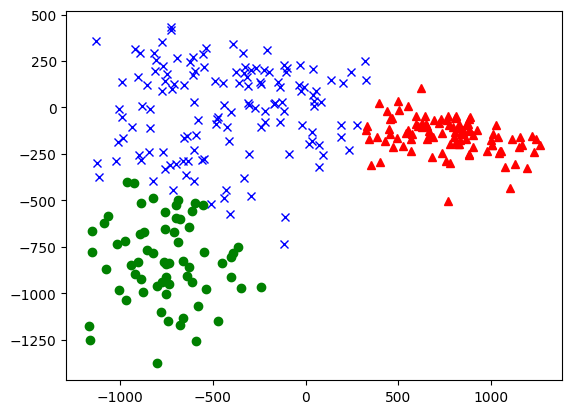

In [10]:
# Plot clusters
common.plot_clusters(new_num_features, clusters, ['xb', '^r', 'og'])

In [11]:
# Perform another analysis using  features 2 and 20 as suggested in office hours
# Get the top two features from the dataframe
top_features_df = generated_num_features.filter(["label"] + [2, 20], axis=1)

# Get 100 class examples of classes [0, 1, 4]
number_classes = common.split_by_class(top_features_df, [0, 1, 4], "label", 100)
new_num_features = common.reformat_df_by_class(number_classes.values())

In [12]:
# set values for expectation maximization algorithm
k = 3

# split data and labels
new_labels, new_features = common.split_labels(new_num_features, "label")
new_features = np.array(new_features)

# get values for expectation maximization algorithm
k, x, m, std, prop = EM.prepare_data_EM(new_features, 3, np.array([0.5377, 1.8339, -2.2588]))

# set the convergence threshold
convergence_threshold = std[1] * 1.0e-6;

# Call expecation maximization algorithm
new_prob, new_m, new_std, prob_ikn, iterations = EM.simple_expectation_maximization(x.T, k, prob, m, std, convergence_threshold)  

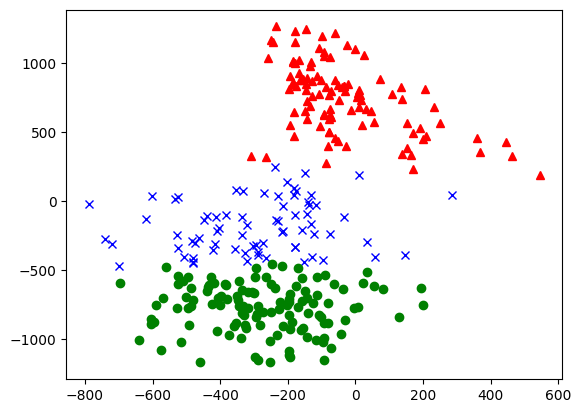

In [13]:
# Get clusters from EM
clusters = EM.get_clusters(prob_ikn, 3)

# Plot clusters
common.plot_clusters(new_num_features, clusters, ['xb', '^r', 'og'])

#### (c) (5 points) Provide an analysis of your results, e.g., what is your observation of the results, how well did the clusters group each class, etc.

The first analysis used FDR feature ranking to determine the best features to separate classes 0, 1, and 4. The second analysis used features 2 and 20 as suggested during office hours. Both implementations generated three distinct clusters for the numerical classes. The expectation-maximization algorithm generated these clusters by calculating the membership probability of each example based on posterior probabilities. 

## Problem 2 - Machine Learning
45 Points Total

In this problem the features generated from HW2 for the numerical data set are to be used. This is the starting point for this problem. A minimum of 5,000 observations need to be used in the problem. A data set developed with the numericalFeatureGeneratorExample.m will also be provided if needed. The updated data is provided as an Excel file with 42,000 observations and 60 features, 20 from each direction. In this assignment data processing and machine learning techniques need to be combined. The ”best” combination is determined by the best classification accuracy.

In [14]:
# Visualize the data
generated_num_features.head()

,label,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,1,538.267964,-314.023125,443.809967,470.780028,176.561668,-336.130920,23.221391,-45.523748,-232.436917,...,-90.463868,107.934027,25.417533,-97.235438,-66.589588,22.468479,-111.476083,62.807185,74.771969,-7.480156
1,0,-238.730010,224.609513,-197.464121,23.557813,-219.122649,-223.695514,-172.689736,125.561839,-194.150108,...,44.464226,-7.825244,-5.260700,18.905444,9.593545,-40.015688,-96.469679,24.317962,-137.943930,94.025390
2,1,51.647165,-27.271305,-185.258708,-50.103687,216.830344,-207.152351,60.301310,95.431402,-117.051561,...,-12.722596,-3.039582,-26.963181,-18.563280,16.095458,-81.075489,-42.589100,52.083444,-29.080312,42.344233
3,4,110.890600,62.854265,-97.528878,-21.291295,297.976619,-32.899732,34.647964,-85.574818,-60.120835,...,23.112458,-62.558569,-115.846264,-16.405413,-37.548852,-269.649782,-130.725868,-23.526366,-20.448849,37.234782
4,0,-300.296735,152.547221,-91.949199,90.416744,-453.385929,-89.195463,-15.051828,-38.036779,-190.363654,...,-28.107534,30.400739,-47.075128,-13.092383,-85.371052,-141.450375,-36.200100,114.188444,-21.988893,-46.480710


In [15]:
# Separate labels and features
num_features_labels, num_features = common.split_labels(generated_num_features.iloc[:5000, :], "label") 

### 1. [5 points] Use a minimum of one of following data preprocessing methods (If more than one method, the processing order is up to you. Built-ins are allowed.):

(a) Data Normalization

(b) Outlier Removal

(c) Feature Ranking and Selection

(d) Dimensionality Reduction

In [16]:
norm_num_features = norm.normalize(num_features)

### 2. [30 points total] Use the following Machine Learning (ML) techniques (built-ins are allowed):

In [17]:
# split data for testing 
train_data, test_data, train_labels, test_labels = common.split_train_test(norm_num_features, num_features_labels, 0.20)
print(f"There are {len(train_labels)} training examples and {len(test_labels)} testing examples.")

There are 4000 training examples and 1000 testing examples.


#### (a) [10 points] Bayes Classifier

In [46]:
# Fit the model with the training dataset
train_set = pd.concat([train_labels, train_data], axis=1)
model = bayes_model.build_model(train_set, [i for i in range(10)], "label")

# Determine classification accuracy with the test dataset
classifications, y_posterior = bayes.bayes_classifier(test_data, model)
labels = list(test_labels)
accuracy = common.get_accuracy(classifications, labels)
print(f"The Bayes classifier had an accuracy of {accuracy}% on the test data.")
common.confusion_matrix(labels, classifications)

The Bayes classifier had an accuracy of 94.7% on the test data.
Confusion Matrix:

Predicted   0    1    2    3   4   5    6   7   8   9
Actual                                               
0          92    0    0    0   0   1    0   0   1   0
1           0  101    3    0   0   0    0   0   8   0
2           1    0  112    0   0   0    0   0   2   0
3           0    0    1  106   0   0    0   0   3   0
4           0    0    1    0  87   0    0   0   0   0
5           0    0    0    5   0  85    0   0   0   0
6           1    0    0    0   0   1  101   0   0   0
7           0    0    3    0   2   0    0  87   1   4
8           1    0    1    2   0   0    0   0  90   0
9           0    0    1    0   6   0    0   3   1  86



#### (b) [10 points] Parzen Window (Gaussian kernel)

In [47]:
classes = [i for i in range(10)]
print("Testing Parzen window algorithm with training and test set")
parzens = parzen.run_parzen_window(train_data, train_labels, test_data, test_labels, classes, 0.1)

Testing Parzen window algorithm with training and test set
Parzen window training...

Training with class 0/9
Training with class 1/9
Training with class 2/9
Training with class 3/9
Training with class 4/9
Training with class 5/9
Training with class 6/9
Training with class 7/9
Training with class 8/9
Training with class 9/9

Accuracy: 91.7%
Confusion Matrix:

Predicted   0    1    2    3   4   5    6   7   8   9
Actual                                               
0          89    1    0    1   0   1    2   0   0   0
1           0  110    1    0   0   0    0   1   0   0
2           1    2  107    0   0   0    0   2   1   2
3           1    0    0  100   0   4    0   1   3   1
4           0    1    0    0  82   0    0   1   0   4
5           0    1    0    4   0  79    2   0   0   4
6           1    0    0    0   0   1  101   0   0   0
7           0    4    0    0   2   0    0  86   0   5
8           2    1    1    2   1   6    0   2  79   0
9           0    2    1    0   4   0    0   

#### (c) [10 points] Neural Network, method of your choice from a built-in

In [48]:
import keras
from keras.models import Sequential
from keras.layers import Dense


labels=keras.utils.to_categorical(train_labels,10)

def multilayer_perceptron(train_data, test_data, train_labels, test_labels, hidden_layers: list, output_activation: str, loss_function: str, show_epochs:bool):
    """
    Create a neural network and evaluate (multiclass only)
    Inputs: data: a normalized dataset
    hidden_layers: an array representing the hidden layers of the neural network. 
                  ex. hidden_layers = [[128, 'relu'], [256, 'relu']] is two hidden
                  layers, one with 128 nodes and one with 256 nodes. Both layers use
                  the relu activation function
    output_activation: The type of activation function in the output layer

    """
    num_classes = len(set(train_labels))
    new_train_labels=keras.utils.to_categorical(train_labels,num_classes)
  
    # Feed forward neural network
    model = Sequential()

    # Hidden layers 
    for i, layer in enumerate(hidden_layers):
        model.add(Dense(layer[0], layer[1], input_dim=60))
    #Output Layer
    model.add(Dense(10, activation=output_activation))

    #Compiling the neural network
    model.compile(optimizer ='adam',loss=loss_function, metrics =['accuracy'])

    if show_epochs:
      history = model.fit(train_data,new_train_labels, batch_size=10, epochs=20)
    else:
      history = model.fit(train_data,new_train_labels, batch_size=10, epochs=20, verbose=0)

    # Get predictions to calculate accuracy and confusion matrix
    predictions = model.predict(test_data, batch_size=10)
    predictions = predictions.argmax(axis=1)
    
    accuracy = common.get_accuracy(list(test_labels), predictions)

    print(f"\nTest accuracy: {accuracy}%\n")

    common.confusion_matrix(list(test_labels), predictions)

    return accuracy
    

multilayer_perceptron(train_data, test_data, train_labels, test_labels, [[128, 'relu'], [256, 'relu']], 'softmax', 'categorical_crossentropy', True)

Epoch 1/20
400/400 [==============================] - 2s 3ms/step - loss: 1.4713 - accuracy: 0.5612
Epoch 2/20
400/400 [==============================] - 1s 3ms/step - loss: 0.6488 - accuracy: 0.8083
Epoch 3/20
400/400 [==============================] - 1s 3ms/step - loss: 0.5115 - accuracy: 0.8470
Epoch 4/20
400/400 [==============================] - 1s 3ms/step - loss: 0.4570 - accuracy: 0.8618
Epoch 5/20
400/400 [==============================] - 2s 4ms/step - loss: 0.4288 - accuracy: 0.8725
Epoch 6/20
400/400 [==============================] - 1s 3ms/step - loss: 0.3998 - accuracy: 0.8752
Epoch 7/20
400/400 [==============================] - 2s 5ms/step - loss: 0.3649 - accuracy: 0.8923
Epoch 8/20
400/400 [==============================] - 2s 5ms/step - loss: 0.3531 - accuracy: 0.8955
Epoch 9/20
400/400 [==============================] - 2s 5ms/step - loss: 0.3356 - accuracy: 0.8978
Epoch 10/20
400/400 [==============================] - 2s 4ms/step - loss: 0.3147 - accuracy: 0.9015

92.8

### 3. [5 points] Use 5-fold cross validation (from HW 3) on selected process from above.

In [18]:
norm_numbers_data = pd.concat([num_features_labels, norm_num_features], axis=1)
print("5-fold validation with the Bayes classifier\n")
bayes.bayes_classifier_k_fold(norm_numbers_data, 5, [i for i in range(10)], "label")

5-fold validation with the Bayes classifier

Experiment 1:

The Bayes classifier had an accuracy of 94.6% on the test data.
Confusion Matrix:

Predicted   0    1    2   3   4   5   6   7   8   9
Actual                                             
0          92    0    0   0   0   0   0   0   1   0
1           0  114    1   0   0   0   0   0   3   0
2           0    0  105   0   0   0   0   1   2   0
3           0    0    3  96   0   2   0   0   2   0
4           0    0    0   0  82   0   0   0   0   1
5           0    0    1   3   0  91   0   0   0   0
6           1    0    0   0   0   1  97   0   0   0
7           1    0    8   0   0   0   0  97   2   5
8           0    0    2   1   0   1   0   0  90   0
9           1    0    1   0   4   0   0   4   2  82

Experiment 2:

The Bayes classifier had an accuracy of 95.0% on the test data.
Confusion Matrix:

Predicted   0   1    2   3   4   5    6   7   8   9
Actual                                             
0          99   0    1   0   0

In [51]:
norm_numbers_data = pd.concat([num_features_labels, norm_num_features], axis=1)
print("5-fold validation with parzen window approach\n")
parzens = parzen.parzen_window_k_fold(norm_numbers_data, 5, [i for i in range(10)], "label", 0.1)

5-fold validation with parzen window approach

Experiment 1 accuracy: 93.2%
Confusion Matrix:

Predicted    0    1   2   3   4   5   6    7   8   9
Actual                                              
0          103    0   0   0   0   0   2    0   0   1
1            0  107   0   0   0   0   0    0   0   1
2            1    1  94   0   0   0   0    0   0   0
3            0    1   2  89   0   0   0    1   2   0
4            0    1   0   0  95   0   1    2   0  10
5            1    2   0   3   1  85   2    1   1   3
6            2    0   0   0   0   0  90    0   0   0
7            0    1   0   0   0   1   0  102   0   1
8            0    4   1   1   0   2   0    0  75   3
9            0    1   2   1   5   0   0    3   0  92

Experiment 2 accuracy: 93.4%
Confusion Matrix:

Predicted   0    1   2   3   4   5   6   7   8   9
Actual                                            
0          98    0   0   0   0   2   2   0   0   0
1           0  133   1   1   0   0   0   2   1   0
2           0   

In [52]:
# K-fold with feed forward neural network
def NN_k_fold(data: object, num_folds: int, label_name: str, hidden_layers: object, output_activation: str, loss_function: str):
    
    experiments = k_fold.k_fold_validation(data, num_folds)
    accuracy_totals = {}
    for experiment in experiments:
        # get test data and convert labels to number
        test_df = experiments[experiment]["test"]
        test_labels = np.array(test_df[label_name])
        data = test_df.drop([label_name], axis=1)
        test_data = np.array(data)
        # get training data and convert labels to numbers
        train_df = experiments[experiment]["train"]
        train_labels = np.array(train_df[label_name])
        data = train_df.drop([label_name], axis=1)
        train_data = np.array(data)
        
        print(f"Experiment {experiment}:")
        acc = multilayer_perceptron(train_data, test_data, train_labels, test_labels, hidden_layers, output_activation, loss_function, False)
        accuracy_totals[experiment] = acc
    print(f"The average accuracy among the experiments was {round(sum(accuracy_totals.values())/len(accuracy_totals), 2)}%")

print("5-fold validation with the feed forward neural network approach\n")
NN_k_fold(norm_numbers_data, 5, "label", [[128, 'relu'], [256, 'relu']], 'softmax', 'categorical_crossentropy')

5-fold validation with the feed forward neural network approach

Experiment 1:
100/100 [==============================] - 0s 1ms/step

Test accuracy: 91.3%

Confusion Matrix:

Predicted   0    1   2   3   4   5    6    7   8   9
Actual                                              
0          90    0   0   0   0   0    1    0   0   0
1           0  103   1   0   0   0    1    1   0   1
2           1    0  99   0   1   0    1    1   3   1
3           0    0   3  89   0   2    0    0   3   1
4           2    0   0   1  75   0    2    0   1  11
5           2    2   0   3   1  66    4    1   5   5
6           0    0   0   0   0   0  101    0   1   1
7           0    0   0   0   0   0    0  114   1   5
8           0    2   0   3   0   0    2    1  82   3
9           0    0   0   2   1   0    0    3   0  94

Experiment 2:
100/100 [==============================] - 0s 1ms/step

Test accuracy: 90.6%

Confusion Matrix:

Predicted    0    1   2   3   4   5    6   7   8   9
Actual                 

### 4. [5 points total] Provide an analysis of your results:

#### (a) [2.5 points] What combination from the above methods gave the best results? The ”best results” is considered the highest classification accuracy for the 10 digits from the 5-fold cross validation results.

The three algorithms were comparable in performance when paired with normalization. All three algorithms had over 90% classification accuracy. The Bayes Classifier had slightly higher classification accuracy than the other methods when tested with 5-fold cross-validation, reaching an average accuracy of 95.02%. 

#### (b) [2.5 points] Was there any part of the combination of the techniques used computationally expensive and why?

The parzen window approach was computationally expensive due to the calculations in the gaussian kernel function used to estimate a probability density function. The neural network was also computationally expensive because it contained multiple hidden layers. The first hidden layer contained 256 nodes, and the second hidden layer contained 128 nodes. The Bayes Classifier was the most computationally efficient approach. 

## Problem 3 - Game Theory
25 Points Total

In the tic-tac-toe code provided add the following method to allow an unbeatable AI in your game.Implement either MiniMax or Alpha Beta to play against and allow the player to choose the skill level.

1. Best Move (Provided) - Skill Level Easy
2. Utility Based Agent (PA1) - Skill Level Medium
3. [25 points] Skill Level Hard - Implemented either the MiniMax or Alpha Beta algorithm from the Game Theory document for the tic-tac-toe game. You will need to alter the provided pseudo code to input the game board.

In [ ]:
#%run -i "game_theory/TicTacProject_Incomplete.py"